In [1]:
% run qpfs_class_draft.ipynb

In [2]:
from model_quality import *
from selector import *
from sklearn.linear_model import LinearRegression

In [3]:
s = Selector(QPFS())
lin = LinearRegression()

In [4]:
q = ModelQuality(s, lin)

In [5]:
import scipy.stats as sps

XX = sps.norm.rvs(size=(100, 5))
X2 = sps.norm.rvs(size=(10, 5))
zz = sps.uniform.rvs(size=(5, 3))
yy = XX @ zz + sps.norm.rvs(scale=0.1, size=(100, 3))
y2 = X2 @ zz + sps.norm.rvs(scale=0.1, size=(10, 3))
maskk = np.ones(XX.shape[1])
maskk[2]=0
maskk[1] = 0
maskk[3] = 0
print(maskk)

metric1 = RSS()
metric2 = Adjusted_Determination_Coefficient()
metric3 = Determination_Coefficient()
metric4 = VIF()
metric5 = BIC()
char1 = Condition_Number()
comp1 = Cp()

[ 1.  0.  0.  0.  1.]


In [6]:
q.fit(XX, yy)#, ns_features = [1, 2, 4])

In [7]:
q.evaluate([metric1, metric2, metric3, metric4, metric5],
                           [comp1], [char1], mode='dynamic')

In [8]:
q.evaluate_info.names

{'Adj Det Coef': 1,
 'BIC': 4,
 'Cond number': 6,
 'Det Coef': 2,
 "Mallow's Cp": 5,
 'RSS': 0,
 'VIF': 3}

In [9]:
q.mean.shape

(7, 5)

In [10]:
q.result.shape

(7, 5, 20)

In [11]:
q.std.shape

(7, 5)

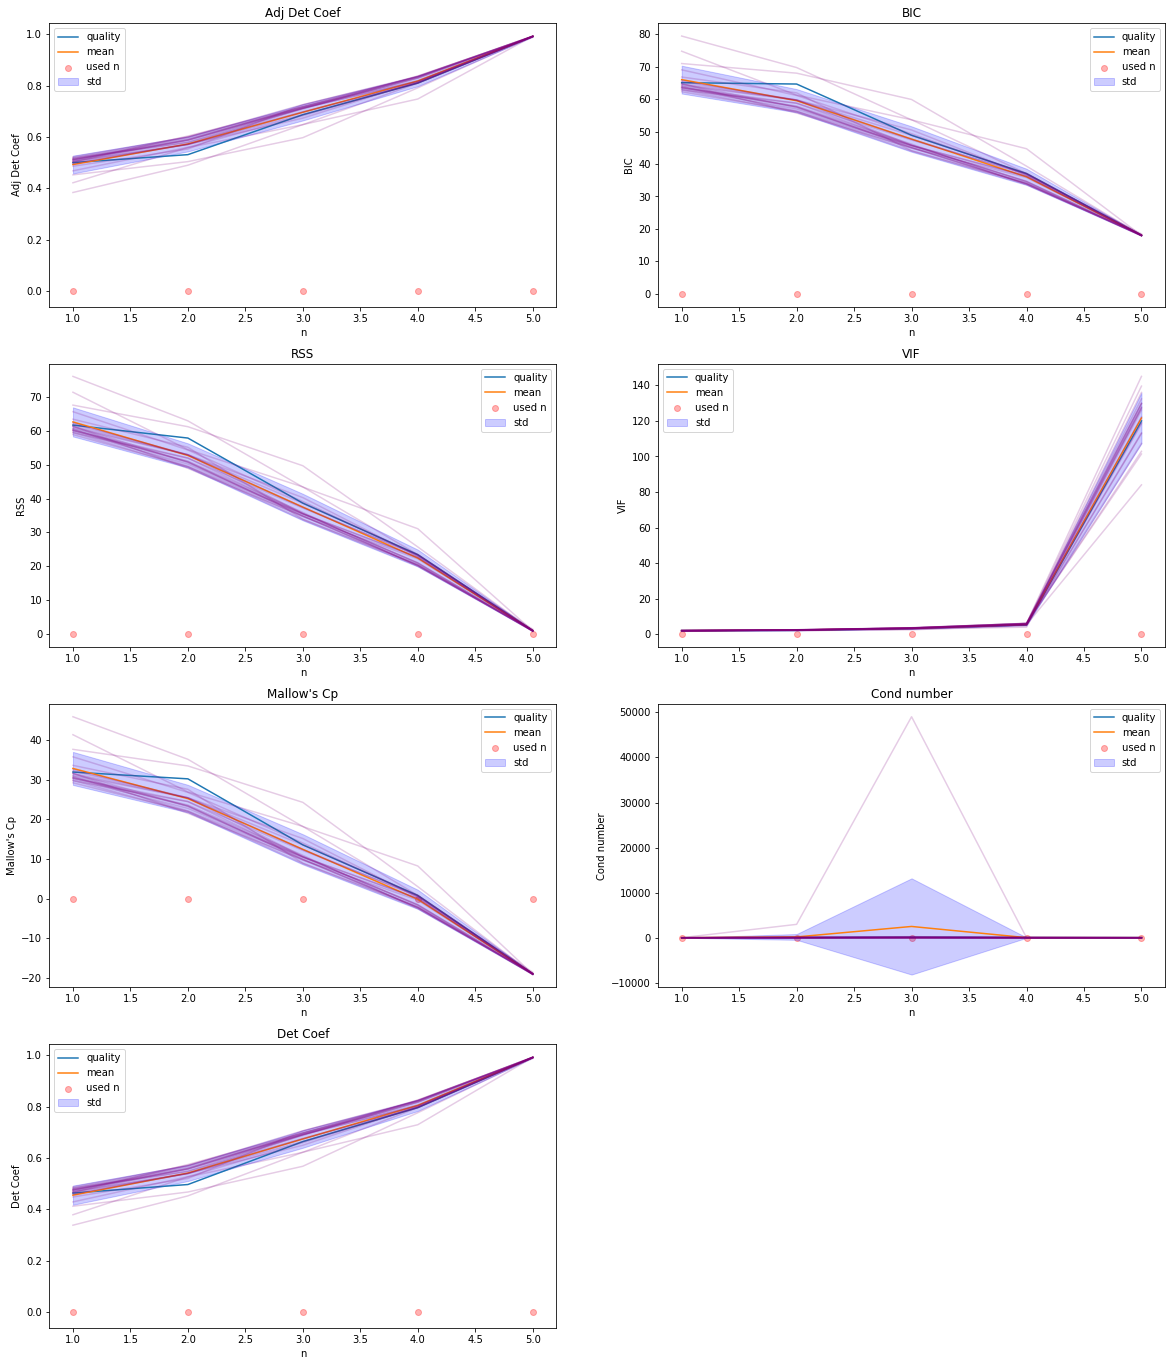

In [12]:
q.draw()

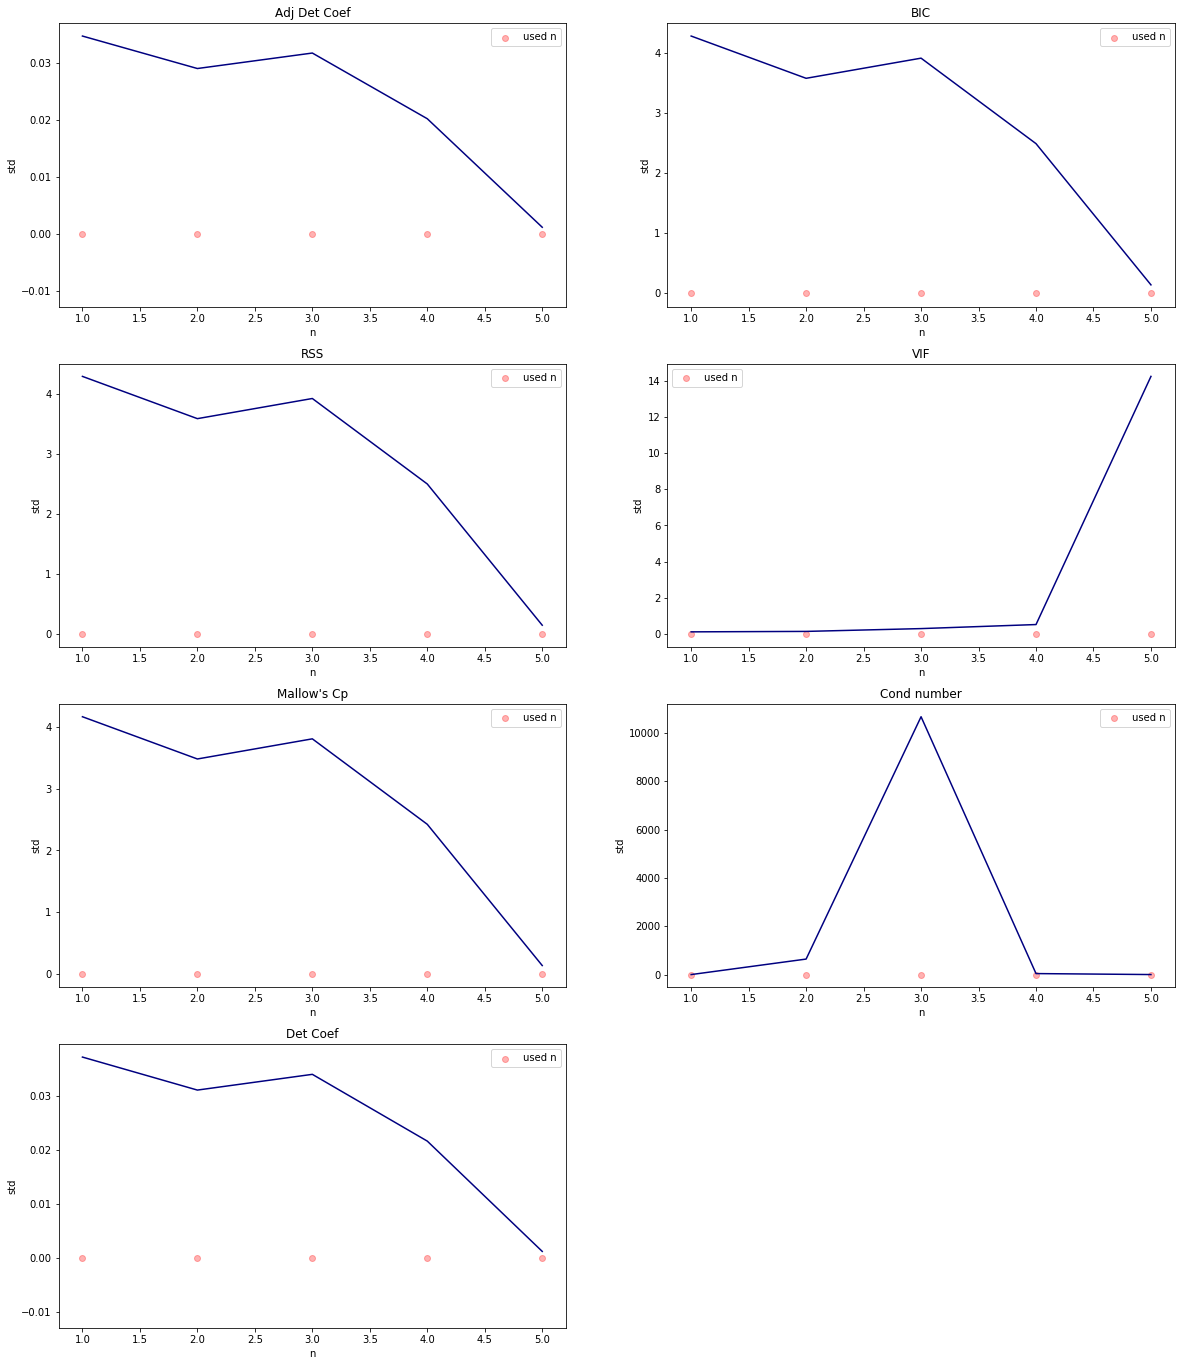

In [13]:
q.draw_std()#['Adj Det Coef','BIC', 'Det Coef', "Mallow's Cp",'RSS', 'VIF', 'Cond number'])

In [20]:
a, b, c = q.check_normality(pandas=True, return_original_p=True, alpha=0.1)

In [21]:
a

,Adj Det Coef,BIC,RSS,VIF,Mallow's Cp,Cond number,Det Coef
1,True,True,True,True,True,True,False
2,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True
5,True,True,True,False,True,True,False


In [22]:
b

,Adj Det Coef,BIC,RSS,VIF,Mallow's Cp,Cond number,Det Coef
1,0.002650,0.002650,0.002650,0.011119,0.002650,0.002650,5.820706e-01
2,0.013297,0.013297,0.013297,0.034550,0.013297,0.013297,2.341205e-10
3,0.009792,0.009792,0.009792,0.047293,0.009792,0.009792,2.121490e-10
4,0.000410,0.000410,0.000410,0.033581,0.000410,0.000410,3.579737e-10
5,0.013297,0.013297,0.013297,0.388014,0.013297,0.013297,5.017646e-01


In [23]:
c

,Adj Det Coef,BIC,RSS,VIF,Mallow's Cp,Cond number,Det Coef
1,0.000098,0.000098,0.000098,0.000654,0.000098,0.000098,5.820706e-01
2,0.000831,0.000831,0.000831,0.006910,0.000831,0.000831,6.885898e-12
3,0.000445,0.000445,0.000445,0.011823,0.000445,0.000445,6.061401e-12
4,0.000013,0.000013,0.000013,0.005597,0.000013,0.000013,1.084769e-11
5,0.000860,0.000860,0.000860,0.129338,0.000860,0.000860,2.508823e-01


Error: std=0


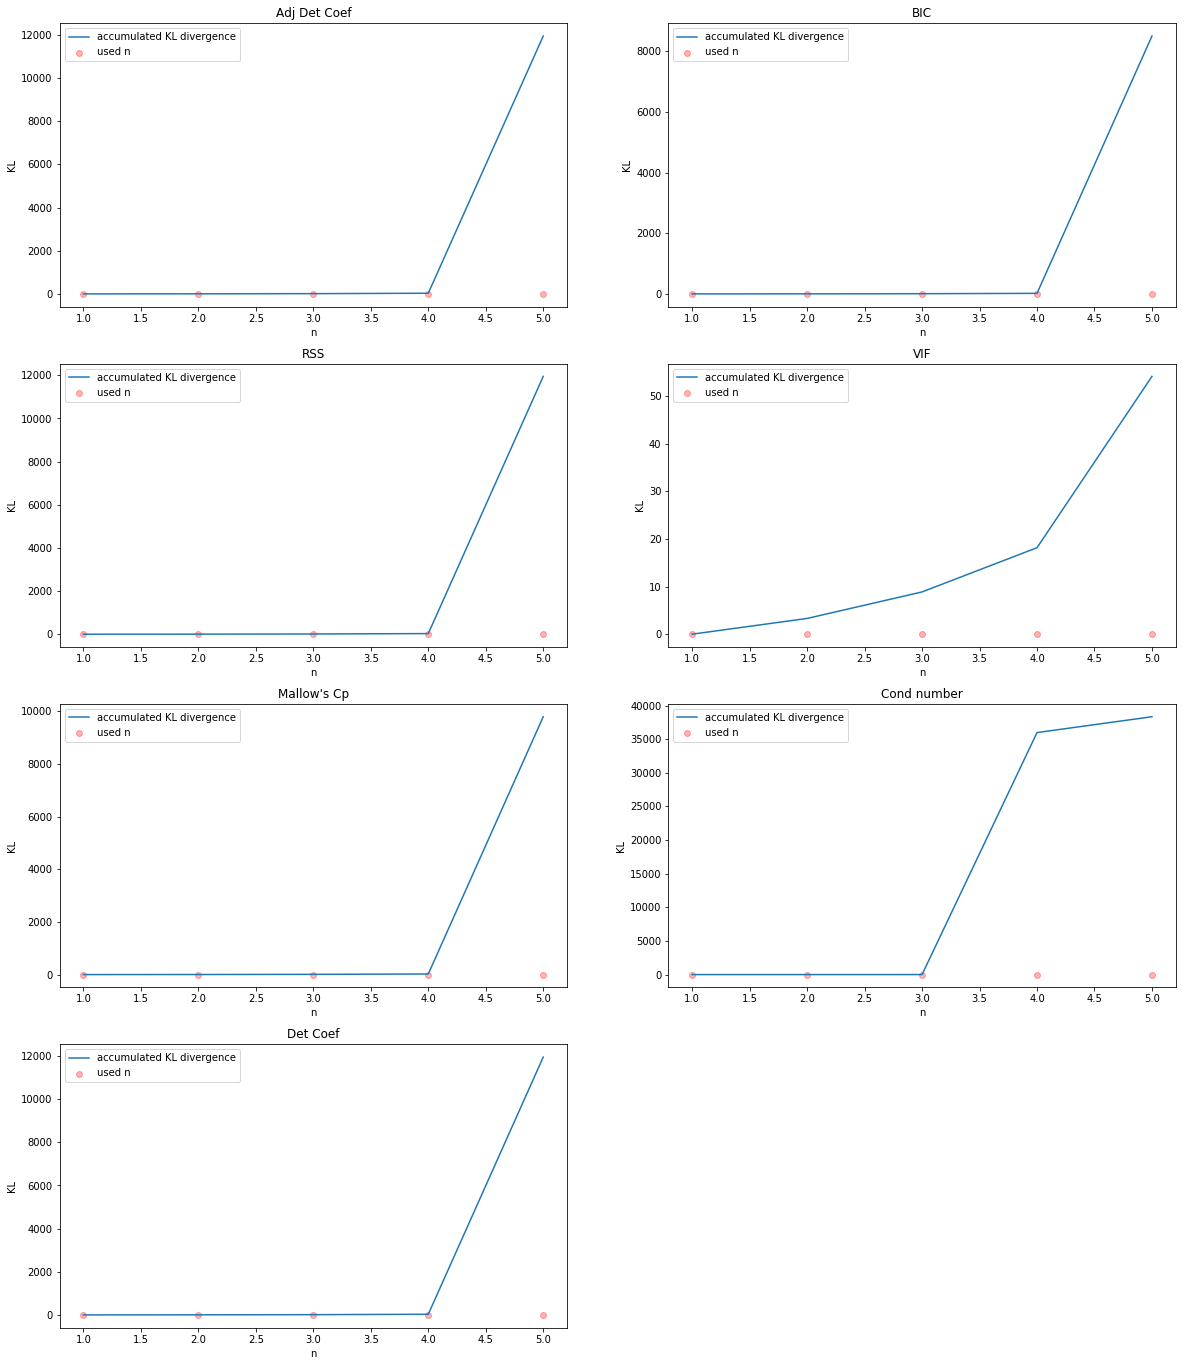

In [24]:
q.draw_KL()

In [19]:
q.summary()

Adj Det Coef :
Min metric test value: 0.500488664765 with n = 0
Max metric test value: 0.99166529838 with n = 4
Min metric average value 0.492830727706 with n = 0
Max metric average value 0.991646602935 with n = 4
Min metric std 0.00113082843978 with n = 4
Max metric std 0.0347319830394 with n = 0
Min metric mean-std 0.458098744667 with n = 0
Max metric mean+std 0.992777431375 with n = 4
Min metric relative std 0.0011403542718 with n = 4
Max metric relative std 0.0704744673715 with n = 0

BIC :
Min metric test value: 18.0346483158 with n = 4
Max metric test value: 65.0504388984 with n = 0
Min metric average value 18.0369556908 with n = 4
Max metric average value 65.99557463 with n = 0
Min metric std 0.139565833006 with n = 4
Max metric std 4.28659023272 with n = 0
Min metric mean-std 17.8973898578 with n = 4
Max metric mean+std 70.2821648627 with n = 0
Min metric relative std 0.00773777101847 with n = 4
Max metric relative std 0.0821694262113 with n = 2

RSS :
Min metric test value: 1.